In [1]:
import numpy as np
import pickle

img = np.zeros((0,0))
with open('img.pickle', 'rb') as file:
    img = pickle.load(file)

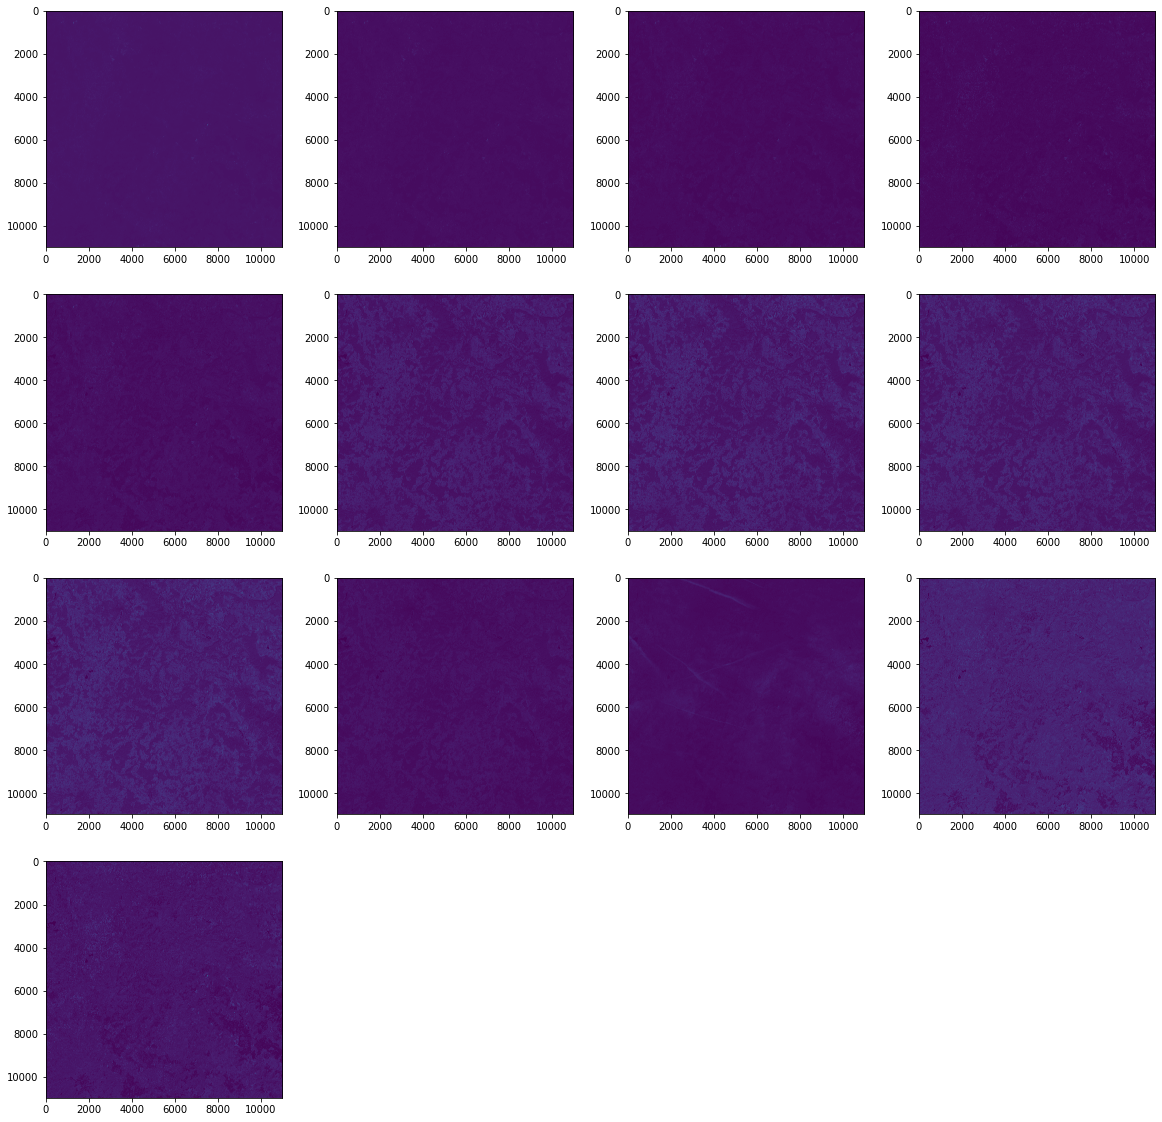

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 20))
for i in range(13):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(img[:, :, i])

In [2]:
import numpy as np
import pickle

scalers = list()
with open('scalers.pickle', 'rb') as file:
    scalers = pickle.load(file)

In [3]:
scaled = np.zeros((img.shape[0], img.shape[1], 13), dtype=np.float32)
for channel in range(13):
    scaled[:, :, channel] = scalers[channel].transform(img[:, :, channel].reshape(-1, 1)).reshape(img.shape[0],img.shape[1])

In [4]:
SHAPE = scaled.shape

In [5]:
scaled

array([[[-0.07634562,  0.21532388,  0.13186415, ..., -1.793045  ,
          1.5221665 , -0.7354048 ],
        [-0.07634562, -0.20154206, -0.11609935, ..., -1.793045  ,
          1.5221665 , -0.7354048 ],
        [-0.07634562, -0.4264697 , -0.36659306, ..., -1.793045  ,
          1.52874   , -0.47640884],
        ...,
        [-0.39841157, -0.48045236, -0.6474497 , ..., -1.7990295 ,
          1.1238097 , -1.0934526 ],
        [-0.39841157, -0.21653724, -0.36406282, ..., -1.7990295 ,
          0.98708   , -1.0341839 ],
        [-0.39841157, -0.2555247 , -0.36406282, ..., -1.7990295 ,
          0.98708   , -1.0341839 ]],

       [[-0.07634562, -0.24352856, -0.23502062, ..., -1.793045  ,
          1.5221665 , -0.7354048 ],
        [-0.07634562,  0.05037693, -0.00729905, ..., -1.793045  ,
          1.5221665 , -0.7354048 ],
        [-0.07634562, -0.33649868, -0.21983919, ..., -1.793045  ,
          1.52874   , -0.47640884],
        ...,
        [-0.39841157, -0.42347068, -0.5259982 , ..., -

In [6]:
del img

In [7]:
patches = list()
for x in range(0, scaled.shape[0] - 64, 64):
    if x == scaled.shape[0] - 64:
        tmp = scaled[-64:, :, :]
    else:
        tmp = scaled[x : x+64, :, :]
    for y in range(0, scaled.shape[1] - 64, 64):
        if y == scaled.shape[1] - 64:
            patches.append(tmp[:, -64:, :])
        else:
            patches.append(tmp[:, y : y + 64, :])

In [8]:
patches = np.array(patches)

In [9]:
patches.shape

(29241, 64, 64, 13)

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 13)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (5, 5), strides=2, activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (5, 5),strides = 2,padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(92, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(92, (5, 5),strides = 2,padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.load_weights('tf-CNN-97%.ckpt')
model.pop()
model.pop()
model.pop()
model.pop()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        3776      
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 29, 29, 64)        2

In [13]:
X_conv = model.predict(patches)

In [14]:
X_conv.shape

(29241, 4508)

In [15]:
del patches

In [16]:
from xgboost import XGBClassifier
with open('xgboost-conv-98,1%.pickle', 'rb') as file:
    model = pickle.load(file)

In [17]:
res = model.predict(X_conv)

In [22]:
colors = [[0, 255, 0], #Annual Crop
          [0, 102, 0], #Forest
          [128, 255, 0], #HerbaceousVegetation
          [96, 96, 96], #Highway
          [255, 255, 0], #Industrial
          [255, 128, 0], #Pasture
          [255, 128, 0], #PermanentCrop
          [127, 0, 255], #Residential
          [0, 128, 255], #River
          [102, 178, 255], #SeaLake
         ]

In [23]:
len(colors)

10

In [25]:
color_map = np.zeros((SHAPE[0], SHAPE[1], 3), dtype=np.uint16)
index = 0
for x in range(0, scaled.shape[0] - 64, 64):
    for y in range(0, scaled.shape[1] - 64, 64):
        color_map[x:x+64,y:y+64,:] = colors[res[index]]
        index += 1

In [24]:
res

array([5, 5, 5, ..., 5, 5, 5], dtype=int64)

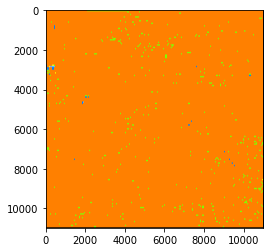

In [29]:
plt.imshow(color_map)